# Ses Tabanlı Duygu Tanıma (Speech Emotion Recognition - SER)

Bu notebook, **CREMA-D** ve **EMO-DB** veri setlerini kullanarak ses dosyalarından duygu tanıma işlemi gerçekleştirmektedir. Proje aşağıdaki adımları içermektedir:

1.  **Veri Artırma (Data Augmentation):** Ses verilerini zenginleştirmek için gürültü ekleme, hızlandırma, perde kaydırma (pitch shift) gibi teknikler kullanılır.(https://www.researchgate.net/publication/372809586_Speech_emotion_recognition_with_light_gradient_boosting_decision_trees_machine)
2.  **Veri Ön İşleme:** Veri seti eğitim, doğrulama ve test olarak ayrılır. StandardScaler ile ölçeklendirme ve PCA ile boyut indirgeme yapılır.(pca şu an yok ama eklenebilir)
3.  **Sınıf Dengesizliği:** SMOTE tekniği ile azınlık sınıfları dengelenir.
4.  **Modelleme ve Değerlendirme:** **LSTM** modeli eğitilir, değerlendirilir ve karşılaştırılır.

In [ ]:
#drive'ı bağlamak için
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Hücre 1: Gerekli Kütüphanelerin Yüklenmesi

Bu hücre, proje için gerekli olan tüm kütüphaneleri yükler. Veri işleme (`pandas`, `numpy`), ses analizi (`librosa`), model oluşturma (`torch`), veri görselleştirme (`matplotlib`, `seaborn`) ve makine öğrenmesi araçları (`sklearn`) gibi temel paketler burada içe aktarılır.

In [ ]:
# Yerel bir ortamda çalışıyorsanız, terminal/komut isteminde aşağıdaki komutu çalıştırın:
# pip install -U scikit-learn imbalanced-learn pandas numpy librosa matplotlib seaborn lightgbm joblib
%pip install --quiet scikit-learn imbalanced-learn resampy torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.2 MB/s eta 0:00:00


In [ ]:
# Gerekli kütüphaneleri yükle
import os
import glob
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings

# Uyarıları gizle
warnings.filterwarnings('ignore')
# Grafikleri notebook içinde göster
%matplotlib inline

### Hücre 2: Veri Yükleme ve Öznitelik Çıkarma Fonksiyonu

Bu hücredeki `load_data` fonksiyonu, belirtilen klasördeki ses dosyalarını okur, her birinden MFCC (Mel-Frequency Cepstral Coefficients) özniteliklerini çıkarır ve etiketleriyle birlikte döndürür.

* **Sabit Uzunluk:** Tüm ses dosyaları aynı uzunluğa getirilir (`fixed_length`). Bu, modelin sabit boyutlu girdilerle çalışmasını sağlar.
* **MFCC Öznitelikleri:** Ses dosyaları, RNN modelinin işleyebileceği zaman serisi formatında MFCC özniteliklerine dönüştürülür.
* **Padding:** Farklı uzunluktaki MFCC dizileri, en uzun diziye göre sıfırlarla doldurularak (padding) aynı boyuta getirilir.

In [ ]:
def load_data(dataset_path, emotion_map, dataset_name, max_per_class=50, fixed_length=32000, use_augmentation=False):
    """Veri setini yükler ve MFCC özniteliklerini çıkarır."""
    features, labels = [], []
    sample_rate = 22050 if dataset_name == 'CREMA-D' else 16000 # EMO-DB için 16 kHz zaten çok daha uzun dosyalar var


    print("çalıştığı path", os.getcwd())
    print("dataset path", dataset_path)


    print(f"{dataset_name} veri seti yükleniyor... (Örnekleme Oranı: {sample_rate})")
    for emotion_code, emotion_name in emotion_map.items():
        # Dosya yolu deseni, dosya adındaki duygu kodunu bulmak için kullanılır.
        path_pattern = os.path.join(dataset_path, emotion_code, '*.wav')
        files = glob.glob(path_pattern)[:max_per_class]

        if not files:
            print(f"Uyarı: {emotion_code} ({emotion_name}) sınıfında dosya bulunamadı.")
            continue
        print(f"-> {emotion_name} sınıfı: {len(files)} dosya bulundu.")

        for file_name in files:
            try:
                # Ses dosyasını yükle
                y, sr = librosa.load(file_name, sr=sample_rate, res_type='kaiser_fast')
                if len(y) == 0:
                    print(f"Uyarı: {file_name} boş veya hatalı.")
                    continue

                # Ses uzunluğunu sabitle
                if len(y) > fixed_length:
                    y = y[:fixed_length]
                else:
                    y = np.pad(y, (0, max(0, fixed_length - len(y))), mode='constant')

                # Veri artırma
                audios = augment_audio(y, sr, fixed_length) if use_augmentation else [y]
                for audio in audios:
                # MFCC özniteliklerini çıkar (RNN için zaman serisi olarak)
                    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                    features.append(mfcc.T)  # (time_steps, n_mfcc)
                    labels.append(emotion_name)
            except Exception as e:
                print(f"Hata: {file_name} işlenemedi. Hata: {str(e)}")

    if not features:
        print(f"Hata: {dataset_name} için hiç öznitelik çıkarılamadı.")
        return np.array([]), np.array([])

    # Aynı boyutta zaman serileri için padding
    max_time_steps = max(f.shape[0] for f in features)
    features_padded = np.array([np.pad(f, ((0, max_time_steps - f.shape[0]), (0, 0)), mode='constant') for f in features])
    labels = np.array(labels)
    print(f"\n{dataset_name}: Toplam {len(features_padded)} örnek, Zaman Adımı: {max_time_steps}")
    return features_padded, labels

In [ ]:
def augment_audio(y, sr, audio2=None, fixed_length=32000):
    """Ses verisini artırmak için çeşitli teknikler uygular."""
    augmented = []

    # Normalizasyon ve boyutlandırma
    y = y / np.max(np.abs(y)) if np.max(np.abs(y)) != 0 else y
    if len(y) > fixed_length:
        y = y[:fixed_length]
    else:
        y = np.pad(y, (0, fixed_length - len(y)), mode='constant')
    augmented.append(y) # Orijinal ses

    # Gürültü Ekleme (Noise)
    noise = y + 0.005 * np.random.randn(len(y))
    augmented.append(noise)

    # Hız Değiştirme (Time Stretch)
    try:
        speed = librosa.effects.time_stretch(y, rate=1.1)
        if len(speed) > fixed_length:
            speed = speed[:fixed_length]
        else:
            speed = np.pad(speed, (0, fixed_length - len(speed)), mode='constant')
        augmented.append(speed)
    except Exception:
        pass

    # Perde Kaydırma (Pitch Shift)
    try:
        vtlp = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-1, 1))
        if len(vtlp) > fixed_length:
            vtlp = vtlp[:fixed_length]
        else:
            vtlp = np.pad(vtlp, (0, fixed_length - len(vtlp)), mode='constant')
        augmented.append(vtlp)
    except Exception:
        pass
    return augmented

### Hücre 3: RNN Modelinin Tanımlanması

Bu hücrede, PyTorch kullanılarak bir Tekrarlayan Sinir Ağı (RNN) modeli tanımlanır. Model, LSTM (Long Short-Term Memory) katmanlarından oluşur. LSTM, zaman serisi verilerindeki uzun süreli bağımlılıkları öğrenmek için oldukça etkilidir.

* `nn.LSTM`: Girdi olarak MFCC dizilerini alır. `batch_first=True` parametresi, tensör boyutlarının (batch, sequence, feature) şeklinde olmasını sağlar.
* `nn.Linear`: LSTM katmanından gelen çıktıyı alarak sınıflandırma yapar.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size=13, hidden_size=128, num_layers=2, num_classes=6, dropout=0.5):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Başlangıç gizli ve hücre durumlarını sıfırla
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM'den geçir
        out, _ = self.lstm(x, (h0, c0))

        # Sadece son zaman adımının çıktısını al ve tam bağlantı katmanına ver
        out = self.fc(out[:, -1, :])
        return out

### Hücre 4: PyTorch Veri Seti Sınıfı

`AudioDataset` sınıfı, öznitelik ve etiketlerimizi PyTorch'un `DataLoader`'ı ile uyumlu hale getirir. Bu özel sınıf, veri setindeki elemanlara indeks ile erişilmesini (`__getitem__`) ve toplam eleman sayısının bilinmesini (`__len__`) sağlar.

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

### Hücre 5: Model Eğitim Fonksiyonu

`train_rnn` fonksiyonu, tanımlanan RNN modelini eğitmek için gereken tüm adımları içerir.

* **Döngü:** Belirtilen `num_epochs` kadar veri seti üzerinde döner.
* **Optimizasyon:** Her adımda kayıp (loss) fonksiyonunu (CrossEntropyLoss) hesaplar ve `Adam` optimizer ile modelin ağırlıklarını günceller.
* **Doğrulama:** Her epoch sonunda modelin performansını doğrulama (validation) seti üzerinde ölçer.
* **En İyi Modeli Kaydetme:** En yüksek doğruluk oranına sahip modelin durumunu (`state_dict`) bir `.pth` dosyasına kaydeder.

In [22]:
def train_rnn(model, train_loader, val_loader, dataset_name, le, learning_rate, num_epochs=20, patience=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    train_losses, val_losses = [], []
    val_accuracies, val_f1s, val_precisions, val_recalls = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Performans metrikleri
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}')

        # En iyi modeli kaydet
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'/content/drive/MyDrive/AudioEmotionDetection/rnn_model_{dataset_name}.pth')
            print(f'--> Yeni en iyi model kaydedildi (Doğruluk: {best_val_acc:.4f})')
            best_epoch = epoch + 1
            best_val_labels = val_labels
            best_val_preds = val_preds
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
              print(f'Erken durdurma: {epoch+1}. epoch’ta eğitim durduruldu.')
              break

    # En iyi model için karışıklık matrisi
    cm = confusion_matrix(best_val_labels, best_val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'RNN ({dataset_name}) En İyi Model Karışıklık Matrisi (Epoch {best_epoch})')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()

    # Eğitim ve doğrulama kayıp eğrileri
    epochs = range(1, len(train_losses) + 1)  # Gerçek epoch sayısına göre
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'r-', label='Eğitim Kaybı')
    plt.plot(epochs, val_losses, 'b-', label='Doğrulama Kaybı')
    plt.title(f'{dataset_name} - Eğitim ve Doğrulama Kayıp Eğrileri')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Doğrulama performans metrikleri grafiği
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, val_accuracies, 'r-', label='Doğruluk')
    plt.plot(epochs, val_f1s, 'b-', label='F1-Skoru')
    plt.plot(epochs, val_precisions, 'g-', label='Hassasiyet')
    plt.plot(epochs, val_recalls, 'm-', label='Duyarlılık')
    plt.title(f'{dataset_name} - Doğrulama Performans Metrikleri')
    plt.xlabel('Epoch')
    plt.ylabel('Değer')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_losses, val_losses, val_accuracies, val_f1s, val_precisions, val_recalls

### Hücre 6: Veri Seti Ayarları ve Yükleme

Bu hücrede, kullanılacak veri setini seçmek için gerekli yapılandırmalar yapılır. Hangi veri setinin (`CREMA-D` veya `EMO-DB`) kullanılacağını `dataset_name` değişkeni ile belirleyebilirsiniz. Dosya yolları ve duygu etiket haritaları da burada tanımlanır. Son olarak `load_data` fonksiyonu çağrılarak veriler yüklenir.

In [ ]:

# Veri seti yolları (Çalıştırılacak ortama göre düzenlenemeli)
BASE_PATH = './' # Eğer notebook ile aynı dizindeyse
CREMA_D_PATH = os.path.join(BASE_PATH, '/content/drive/MyDrive/AudioEmotionDetection/datasets/CREMA-D')#'datasets/CREMA-D'
EMODB_PATH = os.path.join(BASE_PATH, '/content/drive/MyDrive/AudioEmotionDetection/datasets/EMO-DB')#'datasets/EMO-DB'

#6 tane sınıf varr
crema_emotion_map = {
    'HAP': 'Happy',
    'SAD': 'Sad',
    'ANG': 'Angry',
    'FEA': 'Fear',
    'DIS': 'Disgust',
    'NEU': 'Neutral'
}

#7 tane sınıf var, yani rnn modelleri farklı olmalı
emodb_emotion_map = {
    'angry': 'Angry',
    'happy': 'Happy',
    'disgusted': 'Disgust',
    'fearful': 'Fear',
    'surprised': 'Surprised',
    'sad': 'Sad',
    'neutral': 'Neutral'
}


In [ ]:
crema_features, crema_labels = load_data(CREMA_D_PATH, crema_emotion_map, 'CREMA-D', max_per_class=1500, use_augmentation=False)

çalıştığı path /content
dataset path /content/drive/MyDrive/AudioEmotionDetection/datasets/CREMA-D
CREMA-D veri seti yükleniyor... (Örnekleme Oranı: 22050)
-> Happy sınıfı: 1272 dosya bulundu.
-> Sad sınıfı: 1271 dosya bulundu.
-> Angry sınıfı: 1271 dosya bulundu.
-> Fear sınıfı: 1271 dosya bulundu.
-> Disgust sınıfı: 742 dosya bulundu.
-> Neutral sınıfı: 1087 dosya bulundu.

CREMA-D: Toplam 6914 örnek, Zaman Adımı: 63


In [ ]:
aug_crema_features, aug_crema_labels = load_data(CREMA_D_PATH, crema_emotion_map, 'CREMA-D', max_per_class=1500, use_augmentation=True)

çalıştığı path /content
dataset path /content/drive/MyDrive/AudioEmotionDetection/datasets/CREMA-D
CREMA-D veri seti yükleniyor... (Örnekleme Oranı: 22050)
-> Happy sınıfı: 1272 dosya bulundu.
-> Sad sınıfı: 1271 dosya bulundu.
-> Angry sınıfı: 1271 dosya bulundu.
-> Fear sınıfı: 1271 dosya bulundu.
-> Disgust sınıfı: 742 dosya bulundu.
-> Neutral sınıfı: 1087 dosya bulundu.

CREMA-D: Toplam 27656 örnek, Zaman Adımı: 63


In [ ]:
emodb_features, emodb_labels = load_data(EMODB_PATH, emodb_emotion_map, 'EMO-DB', max_per_class=3500, use_augmentation=False)

çalıştığı path /content
dataset path /content/drive/MyDrive/AudioEmotionDetection/datasets/EMO-DB
EMO-DB veri seti yükleniyor... (Örnekleme Oranı: 16000)
-> Angry sınıfı: 3500 dosya bulundu.
-> Happy sınıfı: 3500 dosya bulundu.
-> Disgust sınıfı: 3381 dosya bulundu.
-> Fear sınıfı: 3500 dosya bulundu.
-> Surprised sınıfı: 3445 dosya bulundu.
-> Sad sınıfı: 3500 dosya bulundu.
-> Neutral sınıfı: 3500 dosya bulundu.

EMO-DB: Toplam 24326 örnek, Zaman Adımı: 63


### Hücre 7: Veri Ön İşleme (Etiket Kodlama, Bölme ve Ölçekleme)

Yüklenen veriler model eğitimine hazır hale getirilir.

1.  **Etiket Kodlama (`LabelEncoder`):** Metin tabanlı etiketler (örn: 'Happy', 'Sad') modelin anlayabileceği sayısal değerlere (örn: 0, 1) dönüştürülür.
2.  **Veri Setini Bölme (`train_test_split`):** Veri seti; eğitim, doğrulama ve test olmak üzere üç parçaya ayrılır. Bu, modelin genelleme yeteneğini objektif olarak ölçmemizi sağlar.
3.  **Ölçekleme (`StandardScaler`):** Öznitelik değerleri standartlaştırılır (ortalama 0, standart sapma 1). Bu işlem, modelin daha hızlı ve kararlı bir şekilde öğrenmesine yardımcı olur.

In [ ]:
def encode_scale_split_data(dataset_name, features, labels, use_smote):
    # Etiketleri sayısal formata çevir
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    joblib.dump(le, f'/content/drive/MyDrive/AudioEmotionDetection/label_encoder_rnn_{dataset_name}.pkl')
    print("\nDuygu sınıfları ve kodları:", dict(zip(le.classes_, le.transform(le.classes_))))

    # Veri setini %80 eğitim, %10 doğrulama, %10 test olarak böl
    X_train, X_temp, y_train, y_temp = train_test_split(
        features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"\nEğitim seti boyutu: {X_train.shape[0]}")
    print(f"Doğrulama seti boyutu: {X_val.shape[0]}")
    print(f"Test seti boyutu: {X_test.shape[0]}")

    # Veriyi yeniden şekillendirip ölçekle
    nsamples, nx, ny = X_train.shape
    X_train_reshaped = X_train.reshape((nsamples, nx * ny))
    scaler = StandardScaler().fit(X_train_reshaped)

    # Eğitim setini ölçekle
    X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
    X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)

    # Doğrulama setini ölçekle
    nsamples, nx, ny = X_val.shape
    X_val_scaled_reshaped = scaler.transform(X_val.reshape((nsamples, nx * ny)))
    X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)

    # Test setini ölçekle
    nsamples, nx, ny = X_test.shape
    X_test_scaled_reshaped = scaler.transform(X_test.reshape((nsamples, nx * ny)))
    X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)

    # Test verilerini kaydet
    np.save(f'/content/drive/MyDrive/AudioEmotionDetection/X_test_rnn_{dataset_name}.npy', X_test_scaled)
    np.save(f'/content/drive/MyDrive/AudioEmotionDetection/y_test_rnn_{dataset_name}.npy', y_test)

    print("\nVeri ölçekleme tamamlandı.")

    joblib.dump(scaler, f'/content/drive/MyDrive/AudioEmotionDetection/scaler_rnn_{dataset_name}.pkl')

    # SMOTE (opsiyonel)
    if use_smote:
        smote = SMOTE(random_state=42)
        X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reshaped, y_train)
        X_train_balanced = X_train_balanced.reshape(-1, X_train_scaled.shape[1], X_train_scaled.shape[2])
        print(f"{dataset_name} - SMOTE sonrası eğitim seti boyutu: {X_train_balanced.shape}")
    else:
        X_train_balanced, y_train_balanced = X_train_scaled, y_train

    return X_train_balanced, y_train_balanced, X_val_scaled, y_val, X_test_scaled, y_test, le

### Hücre 8: DataLoader'ların Hazırlanması

Ön işlenmiş eğitim, doğrulama ve test setleri, PyTorch'un `DataLoader` nesnelerine dönüştürülür. `DataLoader`, veriyi mini-batch'lere ayırarak, karıştırarak (`shuffle=True`) ve paralel olarak yükleyerek eğitim sürecini verimli hale getirir.

In [ ]:
# RNN için PyTorch veri setlerini ve DataLoader'ları oluştur
def create_rnn_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    train_dataset = AudioDataset(X_train_balanced, y_train_balanced)
    val_dataset = AudioDataset(X_val_scaled, y_val)
    test_dataset = AudioDataset(X_test_scaled, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

    print("\nDataLoader'lar oluşturuldu.")
    return train_loader, val_loader, test_loader

### Hücre 9: Modelin Başlatılması ve Eğitilmesi

Bu hücrede, `RNNModel` sınıfından bir nesne oluşturulur ve `train_rnn` fonksiyonu çağrılarak eğitim süreci başlatılır. Modelin parametreleri (girdi boyutu, gizli katman boyutu, sınıf sayısı vb.) burada belirlenir. CREMA-D diğer veri setlerinden çok daha küçük olduğu için patience değeri 5 girilir. Ama dropout rate hepsinde aynı ve 0.5 ama EMO-DB için daha agresif bir oran örneğin 0.4 girilebilirdi.(RNNModel constructorında)

In [ ]:
def create_and_train_rnn_model(results, dataset_name, train_loader, val_loader, le, learning_rate, num_epochs=30):
    # RNN modelini başlat
    num_classes = len(le.classes_)
    model = RNNModel(input_size=train_loader.dataset.features.shape[2], hidden_size=64, num_layers=2, num_classes=num_classes)
    # Modeli eğit
    train_losses, val_losses, val_accuracies, val_f1s, val_precisions, val_recalls = train_rnn(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        dataset_name=dataset_name,
        le = le,
        num_epochs=num_epochs,
        learning_rate = learning_rate,
        patience=5 if dataset_name == 'CREMA-D' else 7
    )

    #model, train_loader, val_loader, dataset_name, le, num_epochs=20

    # Sonuçları kaydet
    results.append({
        'Model': ['RNN'],
        'Accuracy': [max(val_accuracies)],
        'F1-Score': [max(val_f1s)],
        'Precision': [max(val_precisions)],
        'Recall': [max(val_recalls)],
        'Dataset': [dataset_name]
    })

In [ ]:
# CREAM-D için modeli eğit
# train_rnn(model, 'CREMA-D', train_loader, val_loader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)

Eğitim 'cpu' üzerinde başlayacak...
Epoch 1/50 | Train Loss: 1.5599 | Validation Accuracy: 0.3905
--> Yeni en iyi model kaydedildi (Doğruluk: 0.3905)
Epoch 2/50 | Train Loss: 1.4312 | Validation Accuracy: 0.4156
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4156)
Epoch 3/50 | Train Loss: 1.3989 | Validation Accuracy: 0.4253
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4253)
Epoch 4/50 | Train Loss: 1.3697 | Validation Accuracy: 0.4368
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4368)
Epoch 5/50 | Train Loss: 1.3476 | Validation Accuracy: 0.4561
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4561)
Epoch 6/50 | Train Loss: 1.3125 | Validation Accuracy: 0.4609
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4609)
Epoch 7/50 | Train Loss: 1.2938 | Validation Accuracy: 0.4474
Epoch 8/50 | Train Loss: 1.2689 | Validation Accuracy: 0.4802
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4802)
Epoch 9/50 | Train Loss: 1.2441 | Validation Accuracy: 0.4860
--> Yeni en iyi model kaydedildi (Doğruluk


==================== CREMA-D VERİ SETİ İŞLENİYOR ====================


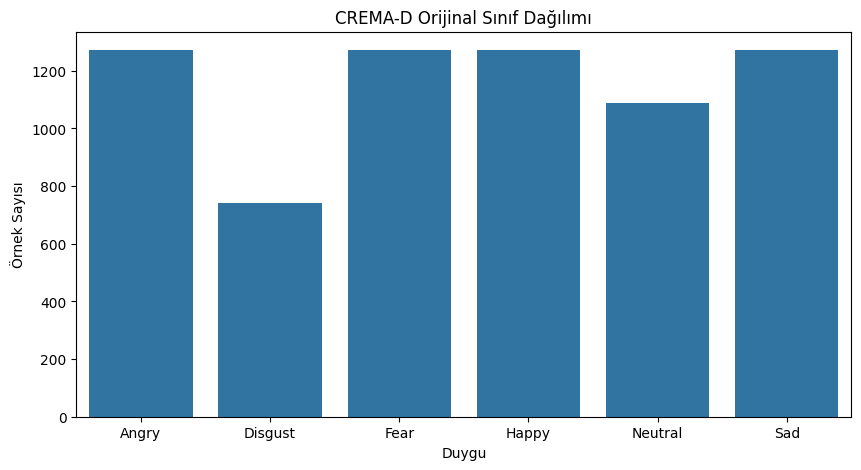


Duygu sınıfları ve kodları: {np.str_('Angry'): np.int64(0), np.str_('Disgust'): np.int64(1), np.str_('Fear'): np.int64(2), np.str_('Happy'): np.int64(3), np.str_('Neutral'): np.int64(4), np.str_('Sad'): np.int64(5)}

Eğitim seti boyutu: 5531
Doğrulama seti boyutu: 691
Test seti boyutu: 692

Veri ölçekleme tamamlandı.
CREMA-D - SMOTE sonrası eğitim seti boyutu: (6102, 63, 13)

DataLoader'lar oluşturuldu.
Epoch 1/30 | Train Loss: 1.5519 | Val Loss: 1.4684 | Val Accuracy: 0.3994
--> Yeni en iyi model kaydedildi (Doğruluk: 0.3994)
Epoch 2/30 | Train Loss: 1.4340 | Val Loss: 1.4586 | Val Accuracy: 0.3864
Epoch 3/30 | Train Loss: 1.3813 | Val Loss: 1.4352 | Val Accuracy: 0.4284
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4284)
Epoch 4/30 | Train Loss: 1.3501 | Val Loss: 1.4481 | Val Accuracy: 0.4023
Epoch 5/30 | Train Loss: 1.3194 | Val Loss: 1.4019 | Val Accuracy: 0.4356
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4356)
Epoch 6/30 | Train Loss: 1.2900 | Val Loss: 1.3920 | Val Accuracy:

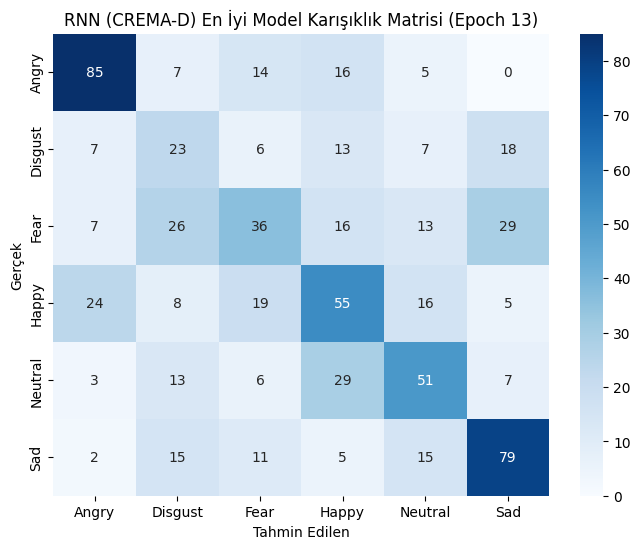

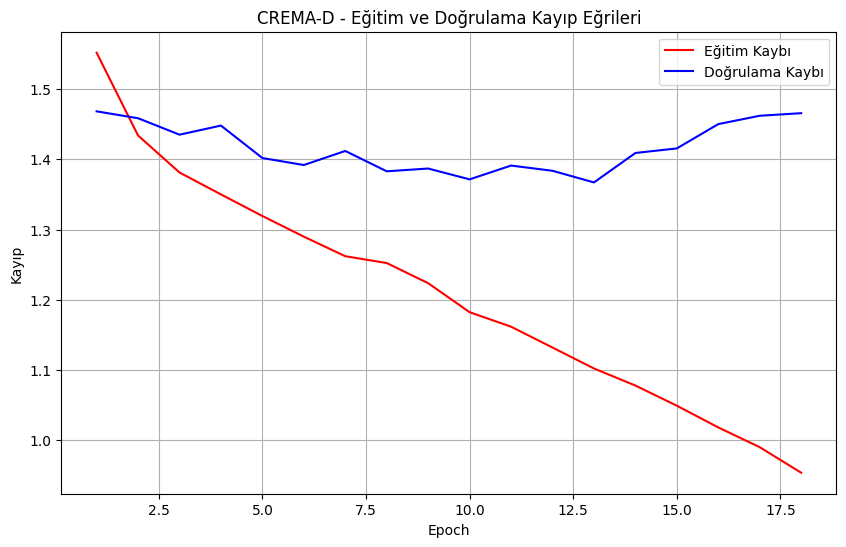

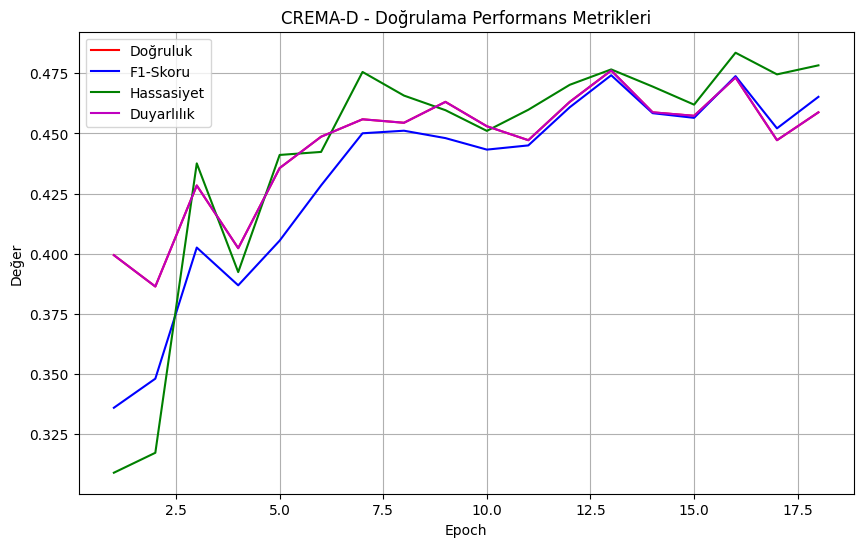


==================== CREMA-D_AUG VERİ SETİ İŞLENİYOR ====================


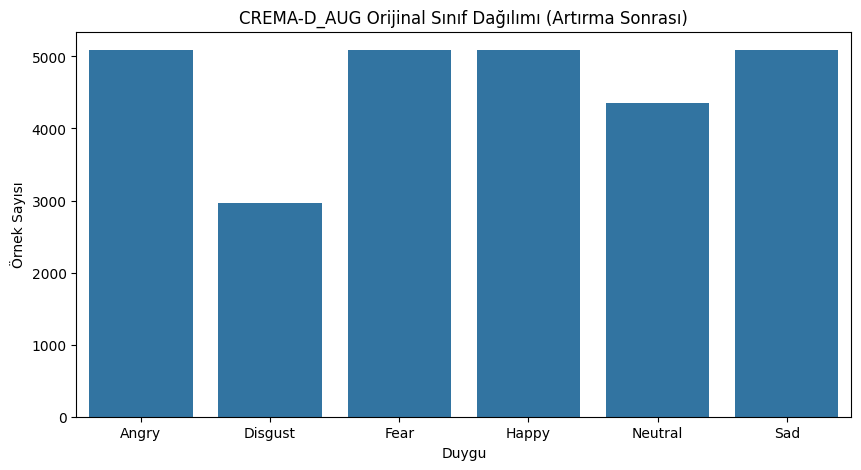


Duygu sınıfları ve kodları: {np.str_('Angry'): np.int64(0), np.str_('Disgust'): np.int64(1), np.str_('Fear'): np.int64(2), np.str_('Happy'): np.int64(3), np.str_('Neutral'): np.int64(4), np.str_('Sad'): np.int64(5)}

Eğitim seti boyutu: 22124
Doğrulama seti boyutu: 2766
Test seti boyutu: 2766

Veri ölçekleme tamamlandı.
CREMA-D_AUG - SMOTE sonrası eğitim seti boyutu: (24420, 63, 13)

DataLoader'lar oluşturuldu.
Epoch 1/30 | Train Loss: 1.4960 | Val Loss: 1.4260 | Val Accuracy: 0.4136
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4136)
Epoch 2/30 | Train Loss: 1.3865 | Val Loss: 1.3190 | Val Accuracy: 0.4761
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4761)
Epoch 3/30 | Train Loss: 1.3028 | Val Loss: 1.2996 | Val Accuracy: 0.4765
--> Yeni en iyi model kaydedildi (Doğruluk: 0.4765)
Epoch 4/30 | Train Loss: 1.2338 | Val Loss: 1.2041 | Val Accuracy: 0.5380
--> Yeni en iyi model kaydedildi (Doğruluk: 0.5380)
Epoch 5/30 | Train Loss: 1.1619 | Val Loss: 1.1848 | Val Accuracy: 0.5510
--> Ye

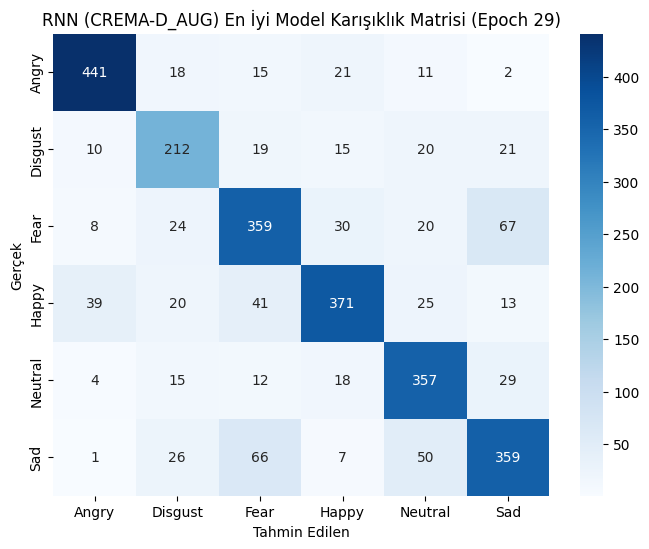

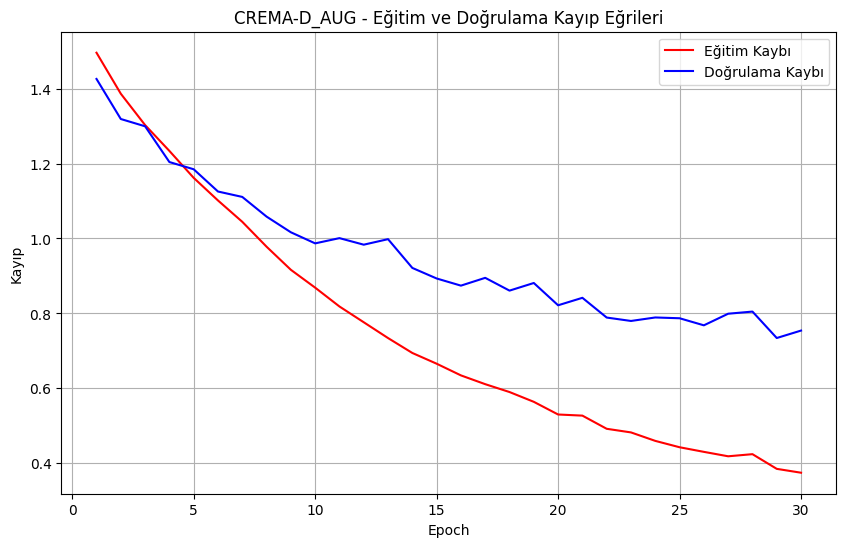

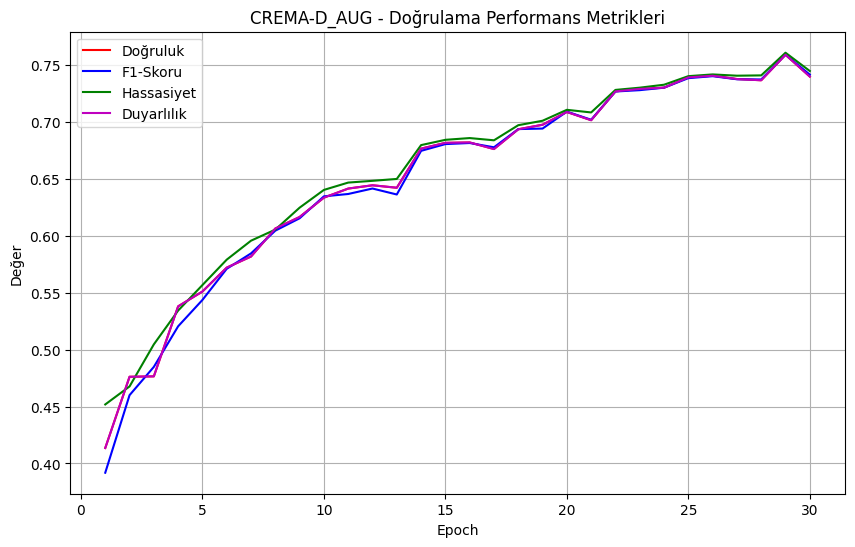


==================== EMO-DB VERİ SETİ İŞLENİYOR ====================


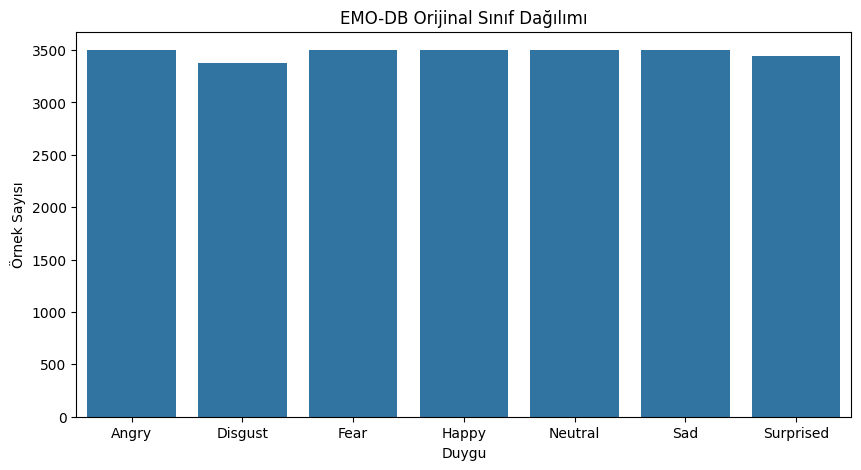


Duygu sınıfları ve kodları: {np.str_('Angry'): np.int64(0), np.str_('Disgust'): np.int64(1), np.str_('Fear'): np.int64(2), np.str_('Happy'): np.int64(3), np.str_('Neutral'): np.int64(4), np.str_('Sad'): np.int64(5), np.str_('Surprised'): np.int64(6)}

Eğitim seti boyutu: 19460
Doğrulama seti boyutu: 2433
Test seti boyutu: 2433

Veri ölçekleme tamamlandı.
EMO-DB - SMOTE sonrası eğitim seti boyutu: (19600, 63, 13)

DataLoader'lar oluşturuldu.
Epoch 1/30 | Train Loss: 1.7722 | Val Loss: 1.7104 | Val Accuracy: 0.3214
--> Yeni en iyi model kaydedildi (Doğruluk: 0.3214)
Epoch 2/30 | Train Loss: 1.6938 | Val Loss: 1.6630 | Val Accuracy: 0.3416
--> Yeni en iyi model kaydedildi (Doğruluk: 0.3416)
Epoch 3/30 | Train Loss: 1.6354 | Val Loss: 1.6161 | Val Accuracy: 0.3670
--> Yeni en iyi model kaydedildi (Doğruluk: 0.3670)
Epoch 4/30 | Train Loss: 1.5805 | Val Loss: 1.5934 | Val Accuracy: 0.3921
--> Yeni en iyi model kaydedildi (Doğruluk: 0.3921)
Epoch 5/30 | Train Loss: 1.5419 | Val Loss: 1.5564

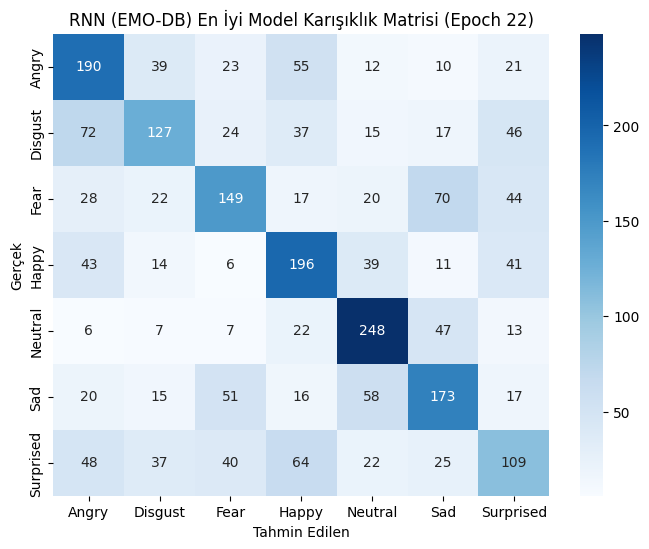

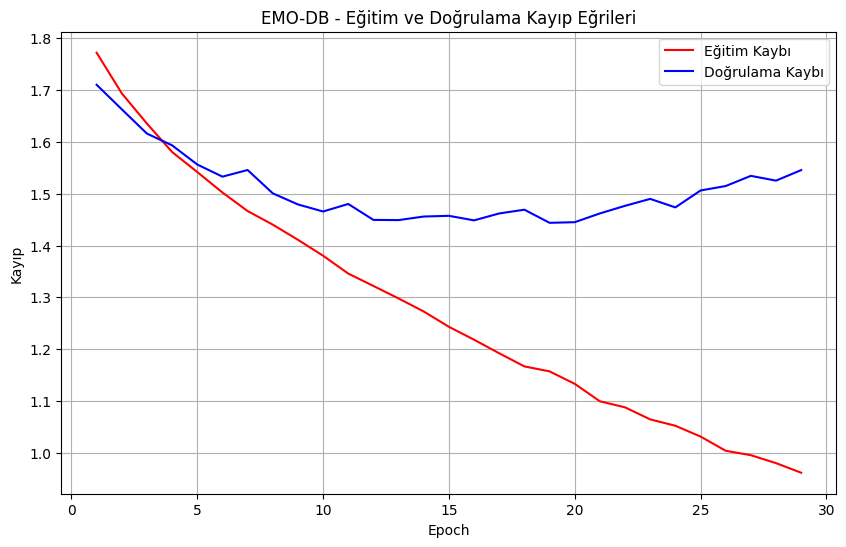

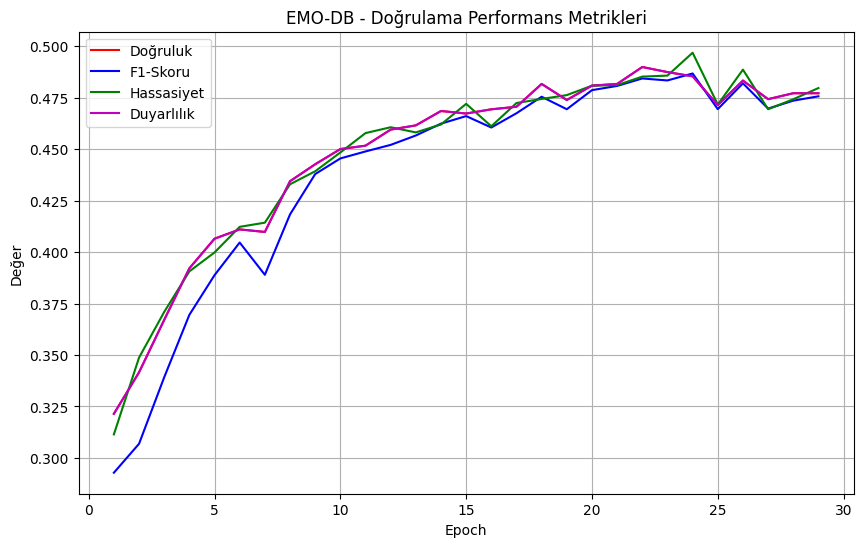

In [23]:
# Ana döngü
results = []
datasets_to_process = [
    ('CREMA-D', crema_features, crema_labels, False),
    ('CREMA-D_AUG', aug_crema_features, aug_crema_labels, True),
    ('EMO-DB', emodb_features, emodb_labels, False)
]
for dataset_name, features, labels, use_augmentation in datasets_to_process:
    print(f"\n{'='*20} {dataset_name} VERİ SETİ İŞLENİYOR {'='*20}")
    if features.size == 0:
        print(f"{dataset_name} veri seti atlanıyor çünkü hiç örnek yüklenemedi.")
        continue

    # Sınıf dağılımını görselleştir
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=unique, y=counts)
    plt.title(f"{dataset_name} Orijinal Sınıf Dağılımı" + (" (Artırma Sonrası)" if dataset_name == "CREMA-D_AUG" else ""))
    plt.xlabel('Duygu')
    plt.ylabel('Örnek Sayısı')
    plt.show()

    X_train_balanced, y_train_balanced, X_val_scaled, y_val, X_test_scaled, y_test, le = encode_scale_split_data(dataset_name, features, labels, True)

    train_loader, val_loader, test_loader = create_rnn_dataloaders(X_train_balanced, y_train_balanced, X_val_scaled, y_val, X_test_scaled, y_test)

    create_and_train_rnn_model(results, dataset_name, train_loader, val_loader, le, learning_rate=0.001, num_epochs=30)



### Hücre 10: Modelin Test Edilmesi ve Sonuçların Değerlendirilmesi

Eğitim tamamlandıktan sonra, en iyi performansı gösteren model (kaydedilen `.pth` dosyası) yüklenir ve train verisi üzerindeki başarımı gösterilir.

* **Doğruluk (`accuracy_score`):** Modelin test setindeki genel başarı oranı hesaplanır.
* **Karışıklık Matrisi (`confusion_matrix`):** Hangi duyguların birbiriyle karıştırıldığını görsel olarak gösteren bir matris oluşturulur. Bu, modelin güçlü ve zayıf yönlerini anlamak için çok önemlidir.

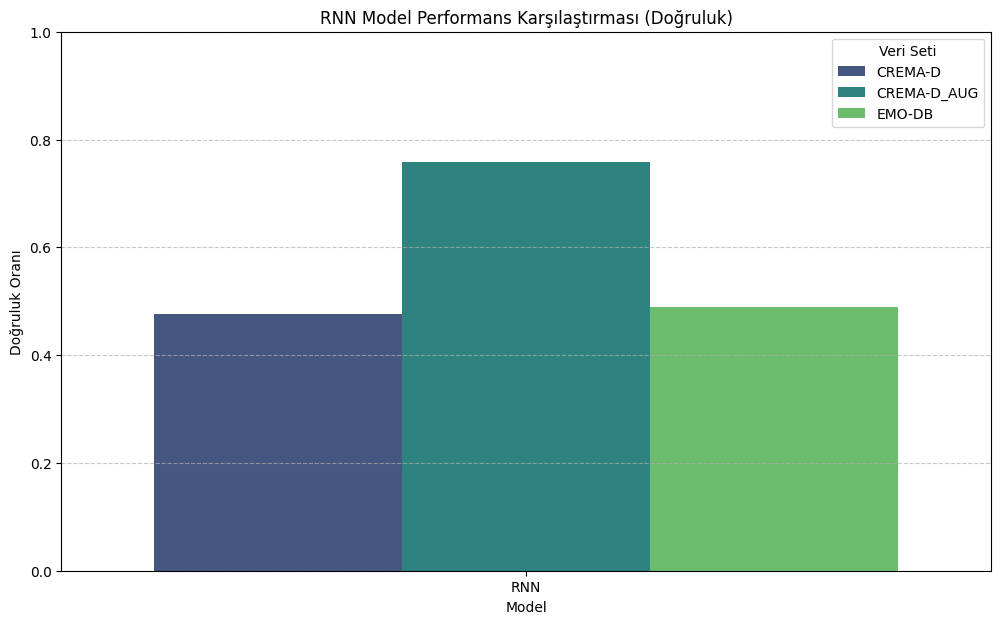

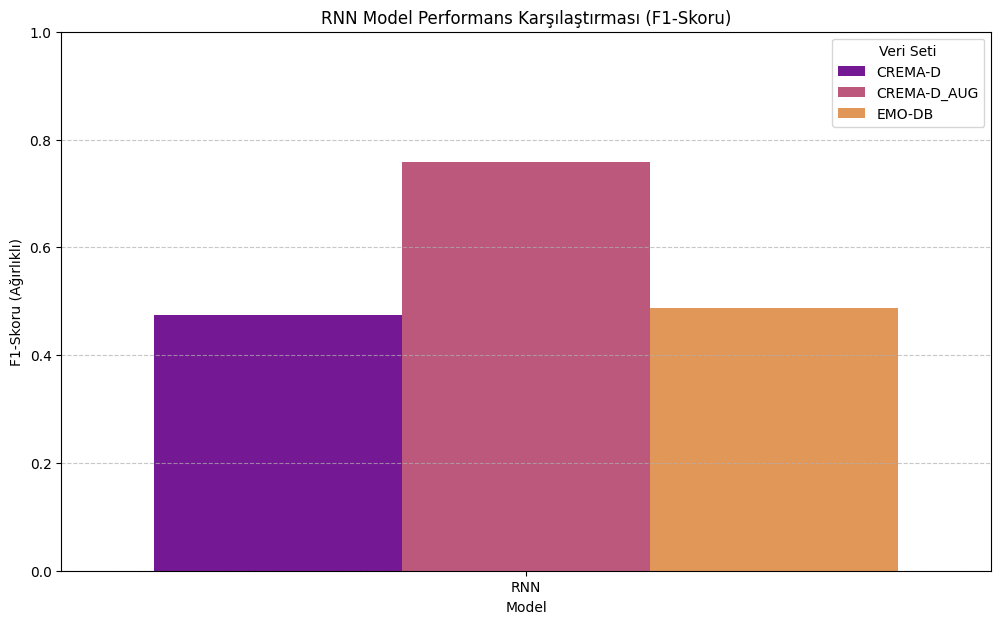

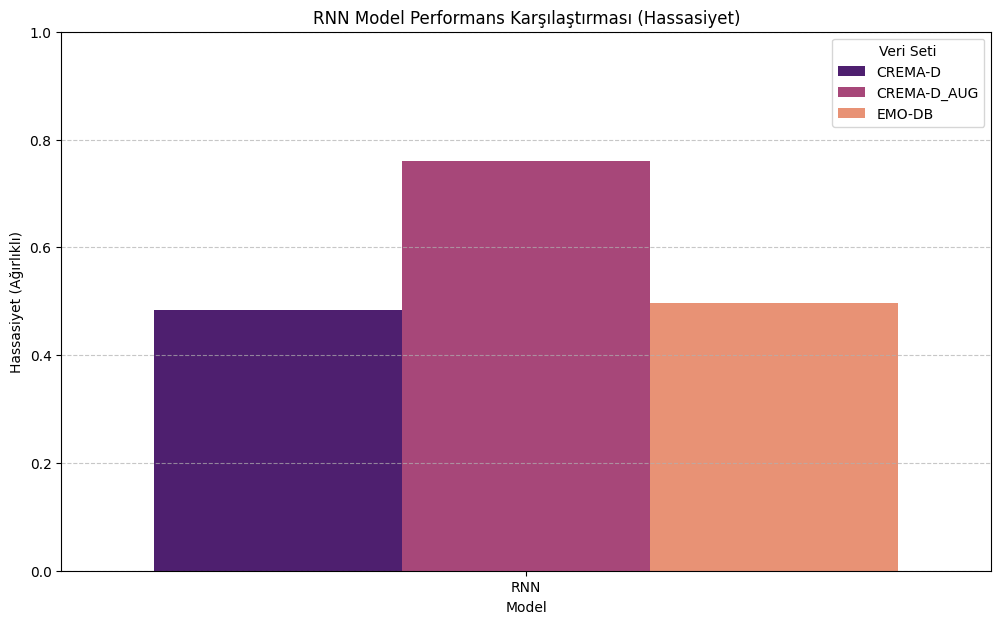

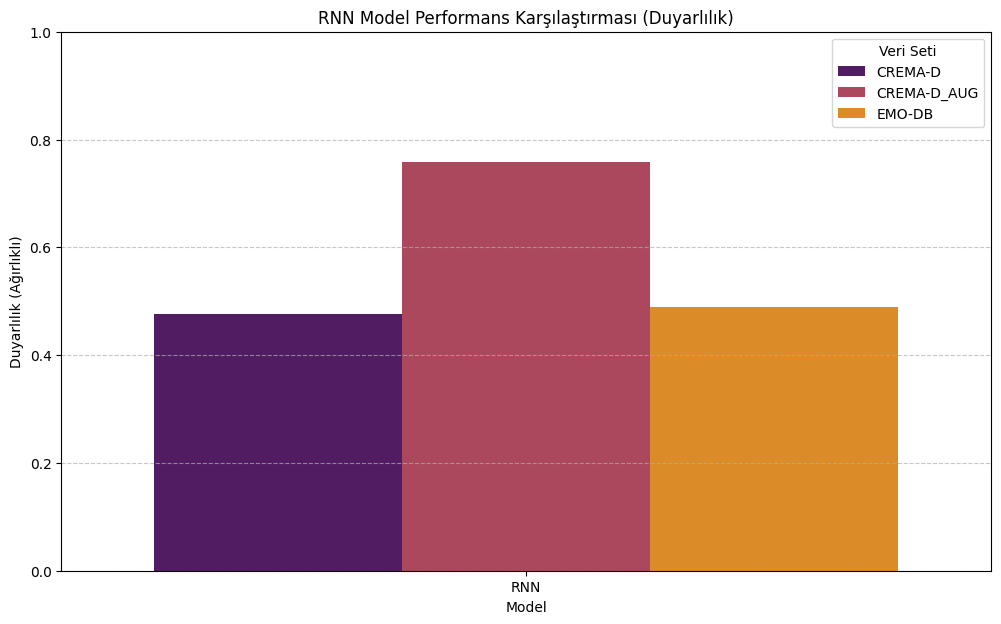

In [25]:
# Tüm veri setlerinin performans karşılaştırması
if results:
    results_df = pd.concat([pd.DataFrame(r) for r in results], ignore_index=True)

    # Doğruluk Karşılaştırması
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=results_df, palette='viridis')
    plt.title('RNN Model Performans Karşılaştırması (Doğruluk)')
    plt.ylabel('Doğruluk Oranı')
    plt.xlabel('Model')
    plt.legend(title='Veri Seti')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # F1-Skoru Karşılaştırması
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Model', y='F1-Score', hue='Dataset', data=results_df, palette='plasma')
    plt.title('RNN Model Performans Karşılaştırması (F1-Skoru)')
    plt.ylabel('F1-Skoru (Ağırlıklı)')
    plt.xlabel('Model')
    plt.legend(title='Veri Seti')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # # Hassasiyet (Precision) Karşılaştırması
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Model', y='Precision', hue='Dataset', data=results_df, palette='magma')
    plt.title('RNN Model Performans Karşılaştırması (Hassasiyet)')
    plt.ylabel('Hassasiyet (Ağırlıklı)')
    plt.xlabel('Model')
    plt.legend(title='Veri Seti')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # # Duyarlılık (Recall) Karşılaştırması
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Model', y='Recall', hue='Dataset', data=results_df, palette='inferno')
    plt.title('RNN Model Performans Karşılaştırması (Duyarlılık)')
    plt.ylabel('Duyarlılık (Ağırlıklı)')
    plt.xlabel('Model')
    plt.legend(title='Veri Seti')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Karşılaştırılacak sonuç bulunamadı.")
